In [1]:
%matplotlib widget
import torch
import warnings
import os
import copy
import subprocess
import shlex
import matplotlib.pyplot as plt
from tqdm import TqdmExperimentalWarning
warnings.filterwarnings("ignore", category=TqdmExperimentalWarning)
from tqdm.autonotebook import tqdm
from torch.profiler import profile,  ProfilerActivity

os.environ['TORCH_CUDA_ARCH_LIST'] = f'{torch.cuda.get_device_properties(0).major}.{torch.cuda.get_device_properties(0).minor}'

from sphMath.sampling import buildDomainDescription, sampleDivergenceFreeNoise
from sphMath.modules.adaptiveSmoothingASPH import n_h_to_nH
from sphMath.plotting import visualizeParticles, updatePlot
from sphMath.integration import getIntegrator
from sphMath.util import volumeToSupport
from sphMath.boundary import sampleDomainSDF
from sphMath.kernels import Kernel_Scale
from sphMath.sdf import getSDF, sdfFunctions, operatorDict, sampleSDF
from sphMath.regions import buildRegion, filterRegion, plotRegions
from sphMath.modules.timestep import computeTimestep
from sphMath.schemes.initializers import initializeSimulation, updateBodyParticles
from sphMath.schemes.deltaSPH import deltaPlusSPHScheme, DeltaPlusSPHSystem
from sphMath.schema import getSimulationScheme
from sphMath.enums import *
import math

RuntimeError: 
undefined value gradientRenormalizationMatrix:
  File "/home/winchenbach/dev/cuMath/src/sphMath/operations.py", line 395
            laplacianMode = laplacianMode,
            consistentDivergence = consistentDivergence,
            gradientRenormalizationMatrix = gradientRenormalizationMatrix,
                                            ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~ <--- HERE
            gradHTerms = gradHTerms
        )    
'SPHOperationCompiled' is being compiled since it was called from 'LiuLiuGhostNodes'
  File "/home/winchenbach/dev/cuMath/src/sphMath/boundary.py", line 124
def LiuLiuGhostNodes(quantities: torch.Tensor, particles: WeaklyCompressibleState, neighborhood: Tuple[SparseNeighborhood, PrecomputedNeighborhood], num_nbrs: torch.Tensor, supportScheme: SupportScheme = SupportScheme.Scatter):
    
    b_scalar = SPHOperationCompiled(
    ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
        particles,
        ~~~~~~~~~~
        quantity = quantities,
        ~~~~~~~~~~~~~~~~~~~~~~
        neighborhood= neighborhood[0],
        ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
        kernelValues= neighborhood[1],
        ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
        operation = Operation.Interpolate,
        ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
        supportScheme= supportScheme,        
        ~~~~~~~~~~~~~~~~~~~~~~~~~~~~ <--- HERE
    )
    b_grad = SPHOperationCompiled(


In [2]:
device = torch.device('cuda:0') if torch.cuda.is_available() else torch.device('cpu')
dtype = torch.float32

nx = 32
L = 2
dim = 2
targetNeighbors = n_h_to_nH(4, dim)
dx = L / nx
area = volumeToSupport(dx**dim, targetNeighbors, dim)
domain = buildDomainDescription(l = L, dim = dim, periodic = True, device = device, dtype = dtype)


kernel = KernelType.Wendland4
integrationScheme = IntegrationSchemeType.symplecticEuler
integrator = getIntegrator(integrationScheme)


freeSurface = False
scheme = SimulationScheme.CompSPH
simulator, SimulationSystem, config, integrator = getSimulationScheme(
     scheme, kernel, integrationScheme, 
     1.0, targetNeighbors, domain)

config['particle'] = {
    'nx': nx,
    'dx': L/nx,
    'targetNeighbors': targetNeighbors,
    'band': 0
}
config['fluid'] = {
    'rho0': 1,
    'c_s': 10,
    'gamma': 1.4
}
config['surfaceDetection']['active'] = freeSurface
config['shifting']['freeSurface'] = freeSurface

NameError: name 'n_h_to_nH' is not defined

In [ ]:
fluid_sdf = lambda x: sampleDomainSDF(x, domain, invert = True)

regions = []
regions.append(buildRegion(sdf = fluid_sdf, config = config, type = 'fluid'))

for region in regions:
    region = filterRegion(region, regions)

True: dxs: [tensor(0.0625, device='cuda:0'), tensor(0.0625, device='cuda:0')], ns: [tensor(32, device='cuda:0', dtype=torch.int32), tensor(32, device='cuda:0', dtype=torch.int32)], nx: 32


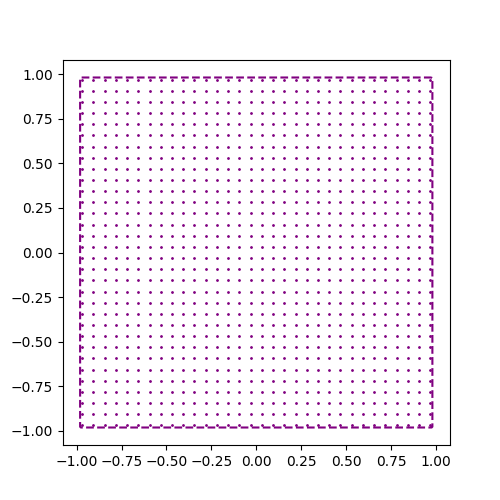

In [ ]:
fig, axis = plt.subplots(1, 1, figsize=(5, 5), squeeze=False)
    
plotRegions(regions, axis[0,0], plotFluid = True, plotParticles = True)


In [ ]:
particleState, config, rigidBodies = initializeSimulation(scheme, config, regions)
particles = copy.deepcopy(particleState)

particles.positions += torch.randn_like(particles.positions) * particles.supports.view(-1,1) * 0.001

In [ ]:
from sphMath.neighborhood import evaluateNeighborhood, filterNeighborhoodByKind, coo_to_csr, SupportScheme

neighborhood = None
neighborhood, neighbors = evaluateNeighborhood(particles, domain, kernel, verletScale = config['neighborhood']['verletScale'], mode = SupportScheme.SuperSymmetric, priorNeighborhood=neighborhood)
particles.numNeighbors = coo_to_csr(filterNeighborhoodByKind(particles, neighbors.neighbors, which = 'noghost')).rowEntries


In [ ]:
from sphMath.modules.density import computeDensity

rho = computeDensity(particles, kernel, neighbors.get('noghost'), SupportScheme.SuperSymmetric, config)

In [ ]:
from sphMath.modules.CRKSPH import computeGeometricMoments, computeCRKTerms, computeCRKVolume

particles.V = computeCRKVolume(particles, kernel, neighbors.get('noghost'), SupportScheme.SuperSymmetric, config)

kernelMoments = computeGeometricMoments(particles, kernel, neighbors.get('noghost'), SupportScheme.SuperSymmetric, config)
A, B, gradA, gradB = computeCRKTerms(kernelMoments, particles.numNeighbors)

In [ ]:
from sphMath.modules.adaptiveSmoothing import computeOmega
omega = computeOmega(particles, kernel, neighbors.get('noghost'), SupportScheme.Gather, config)


In [ ]:
from sphMath.modules.renorm import computeCovarianceMatrices

C, L, *_ = computeCovarianceMatrices(particles, kernel, neighbors.get('normal'), SupportScheme.Scatter, config)


In [ ]:
from dataclasses import dataclass
from typing import Optional
from enum import Enum

class KernelCorrectionScheme(Enum):
    NoCorrection = 0
    CRKSPH = 1
    gradientRenorm = 2
    gradH = 3

@dataclass(slots = True)
class KernelTerms:
    # CRK-SPH Terms:
    A: Optional[torch.Tensor] = None
    B: Optional[torch.Tensor] = None
    gradA: Optional[torch.Tensor] = None
    gradB: Optional[torch.Tensor] = None

    # Kernel Gradient Renormalization
    gradCorrectionMatrices: Optional[torch.Tensor] = None

    # grad-H Term:
    omega: Optional[torch.Tensor] = None



In [ ]:
KernelTerms()

KernelTerms(A=None, B=None, gradA=None, gradB=None, L=None, omega=None)

In [3]:
from typing import Union
from sphMath.schemes.states.compressiblesph import CompressibleState
from sphMath.schemes.states.common import BasicState
from sphMath.schemes.states.wcsph import WeaklyCompressibleState

@torch.jit.script
def get_attr(particles: Union[BasicState, CompressibleState, WeaklyCompressibleState], attr: str):
    if hasattr(particles, attr):
        return getattr(particles, attr)
    else:
        raise ValueError('No matching attribute in class')

RuntimeError: 
hasattr's second argument must be a string literal:
  File "/tmp/ipykernel_321902/11786700.py", line 8
@torch.jit.script
def get_attr(particles: Union[BasicState, CompressibleState, WeaklyCompressibleState], attr: str):
    if hasattr(particles, attr):
                          ~~~~ <--- HERE
        return getattr(particles, attr)
    else:
